In [9]:
import pandas
import os
import itertools
import numpy as np
import nibabel as ni
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from nilearn import image
from nilearn import plotting
import wordcloud
import PIL

In [10]:
git_dir = '/home/users/jvogel/git/Hippocampus_AP_Axis/'
import sys
sys.path.insert(0,git_dir)

import HAP_Utils as hap

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


# Get hippocampus samples

Running NB1 required to load these documents

In [2]:
wdir = '/data1/users/jvogel/Allen_Human_Brain_Atlas/'
df = pandas.read_csv(os.path.join(wdir,'MAIN_hippocampus_sample_info.csv'))
xp = pandas.read_csv(os.path.join(wdir,'MAIN_hippocampus_gxp.csv'),index_col=0)
gdf = pandas.read_csv(os.path.join(wdir,'MAIN_gcx_wholebrain_info.csv'))
probes = pandas.read_csv(os.path.join(wdir,'normalized_microarray_donor9861/Probes.csv'))

Download instructions
================

For this Notebook, you will need to download all 100 topic/coactivation association maps from the metanalytic LDA analysis on the Neurosynth website. Here's how to do that:
* Go to http://neurosynth.org/analyses/topics/
* Click on v4-topics-100
* For EACH OF THE 100 MAPS:
    * Click the topic number (e.g. Topic 000)
    * Under the heading "layers", the top row will contain buttons for the association maps. Hit the rightmost button to download the associaion map (see screenshot below). Be sure you are downloading the association maps, NOT the uniformity maps.
* When all 100 maps have been downloaded, move them to a centralized location

![title](NS_DL_doc.png)


In [3]:
# Change this to the directory where you stored all 100 association maps
metadir = '/home/users/jvogel/Science/Allen_Human_Brain_Atlas/cognition_mri_analysis/all_maps_RI/'

In [ ]:
# If you wish to save images to disk, uncomment and change
# fig_dir = '/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/'

# Cognitive fmri meta-analysis

Collect all 100 reverse inference maps downloaded from Neurosynth

In [7]:
metascans = sorted(glob(os.path.join(metadir,'v*.nii.gz')))
print(len(metascans))
metascans[0]

100


'/home/users/jvogel/Science/Allen_Human_Brain_Atlas/cognition_mri_analysis/all_maps_RI/v4-topics-100_0_stimulation_somatosensory_tms_pFgA_z_FDR_0.01.nii.gz'

In [8]:
# Assign labels to the maps describing the topic number, the first two words, and the image type (pFgA) 
metalabs = ['T%s_%s_%s'%(os.path.split(x)[-1].split('_')[1],
                         os.path.split(x)[-1].split('_')[2],
                            os.path.split(x)[-1].split('_')[3]) 
            for x in metascans]
metares_a = pandas.DataFrame(index=gdf.index,columns = metalabs)
metares_a.shape

(3702, 100)

In [8]:
# Load all maps at once (might give trouble to slow computers, takes a few moments on fast computers)
allmetas = image.load_img(metascans).get_data()

Here, we are interested in which samples overlap with each map. Once we figure out which samples overlap with the map, we average the value of all samples within a map to get a single value representing the average HAGGIS of regions falling within each map. This can give us a sense of the shared genomic contributors with the hippocampus (HAGGIS) present in different behavioral networks (maps)

In [9]:
col = 'AP_axis_gxp_signature_similarity_SPCR'

# for each coordinate
for i,row in gdf.iterrows():
    # draw a 6mm cube around the coordinate
    xs,ys,zs = hap.make_sphere(hap.convert_coords([row['mni_nlin_x'],row['mni_nlin_y'],row['mni_nlin_z']],'xyz',2), 3)
    # for each image
    for img in range(allmetas.shape[-1]):
        # if there is any data inside the cube (i.e. if the sample falls within the map)
        if allmetas[xs,ys,zs,img].mean() > 0:
            # add data for this sample to spreadsheet (i.e. mark this sample as within the map)
            metares_a.loc[i,metalabs[img]] = row[col]
    if i%100 == 0:
        print('finished %s of 3702'%i)

finished 0 of 3702
finished 100 of 3702
finished 200 of 3702
finished 300 of 3702
finished 400 of 3702
finished 500 of 3702
finished 600 of 3702
finished 700 of 3702
finished 800 of 3702
finished 900 of 3702
finished 1000 of 3702
finished 1100 of 3702
finished 1200 of 3702
finished 1300 of 3702
finished 1400 of 3702
finished 1500 of 3702
finished 1600 of 3702
finished 1700 of 3702
finished 1800 of 3702
finished 1900 of 3702
finished 2000 of 3702
finished 2100 of 3702
finished 2200 of 3702
finished 2300 of 3702
finished 2400 of 3702
finished 2500 of 3702
finished 2600 of 3702
finished 2700 of 3702
finished 2800 of 3702
finished 2900 of 3702
finished 3000 of 3702
finished 3100 of 3702
finished 3200 of 3702
finished 3300 of 3702
finished 3400 of 3702
finished 3500 of 3702
finished 3600 of 3702
finished 3700 of 3702


In [10]:
# calculate the size of each map
map_sizes = []
for i in range(allmetas.shape[-1]):
    jnk = allmetas[:,:,:,i]
    map_sizes.append(len(jnk[jnk>0]))

In [11]:
# we don't need the image data anymore, so let's get rid of it (its taking up a lot of memory)
del(allmetas)

In [12]:
# calculate the number of samples found within each map
map_hits = []
for col in metares_a.columns:
    jnk = metares_a[col]
    map_hits.append(len([x for x in jnk.values if pandas.notnull(x)]))

In [13]:
# create a spreadsheet summarizing all of the relevant information

# create spreadsheet
res_sum = pandas.DataFrame(index = metares_a.columns)
res_sum.loc[:,'mean'] = metares_a.mean().values # average HAGGIS of samples within map
res_sum.loc[:,'sem'] = metares_a.sem().values # SEM of HAGGIS of samples within map
res_sum.loc[:,'map_size'] = map_sizes # size (in voxels) of each map
res_sum.loc[:,'map_hits'] = map_hits # number of samples falling within each map

In [14]:
res_sum.sort_values('mean').head()

,mean,sem,map_size,map_hits
T29_delay_delayed,-0.060289,0.006142,47,30
T93_eye_eyes,-0.036209,0.001827,9192,526
T50_learning_training,-0.032454,0.003734,155,100
T9_attention_attentional,-0.031600,0.002255,6355,286
T88_motion_perception,-0.031015,0.002674,6100,231


In [15]:
# Just in case someone asks for it, create a new mean weighted by number of samples in each map
cols = ['mean','sem']
for col in cols:
    wtd = (res_sum[col].values * res_sum.map_hits.values
          ) / (res_sum[col].values + res_sum.map_hits.values)
    res_sum.loc[:,'wtd_%s'%col] = wtd

In [16]:
res_sum.sort_values('mean').head()

,mean,sem,map_size,map_hits,wtd_mean,wtd_sem
T29_delay_delayed,-0.060289,0.006142,47,30,-0.060410,0.006141
T93_eye_eyes,-0.036209,0.001827,9192,526,-0.036211,0.001827
T50_learning_training,-0.032454,0.003734,155,100,-0.032464,0.003734
T9_attention_attentional,-0.031600,0.002255,6355,286,-0.031603,0.002255
T88_motion_perception,-0.031015,0.002674,6100,231,-0.031019,0.002674


In [17]:
# How many (of the 100 maps) actually overlap with some samples?
goodlabs = metares_a.mean().dropna().index
len(goodlabs)

90

In [18]:
# Get rid of those that don't and sort data
metaresb = metares_a[goodlabs]
metaresb = metaresb[metaresb.mean().sort_values().index]

Here, we apriori identify to topic sets that we feel should overlap with the AT or PM system, based on comparing the words in the topic lists with the descriptions of the AT/PM systems in Ranganath and Ritchey (2012)

In [19]:
# Identify topics for each system
ATLabs = ['T65','T60','T17','T20','T90']
PMLabs = ['T56','T24','T40','T14','T75']

# parse topic number and add system to relevant topics
for top in res_sum.index:
    tnum = top.split('_')[0]
    if tnum in ATLabs:
        res_sum.loc[top,'system'] = 'AT'
    elif tnum in PMLabs:
        res_sum.loc[top,'system'] = 'PM'
res_sum2 = res_sum.loc[metaresb.columns]

Here, we get only retain samples that have at least 500 samples, to ensure we are not getting enough data

In [20]:
goodlabs = res_sum[res_sum.map_hits>500].index
len(goodlabs)
metares500 = metares_a[goodlabs]
metares500 = metares500[metares500.mean().sort_values().index]

In [21]:
# How many maps does that leave us with?
res_sum4 = res_sum.loc[metares500.columns]
res_sum4.shape

(29, 7)

Finally, we plot the results. We would like to see the mean (and SEM) HAGGIS of samples falling within maps overlapping with at least 400 samples. We want values in the AT and PM system to be color coded. 

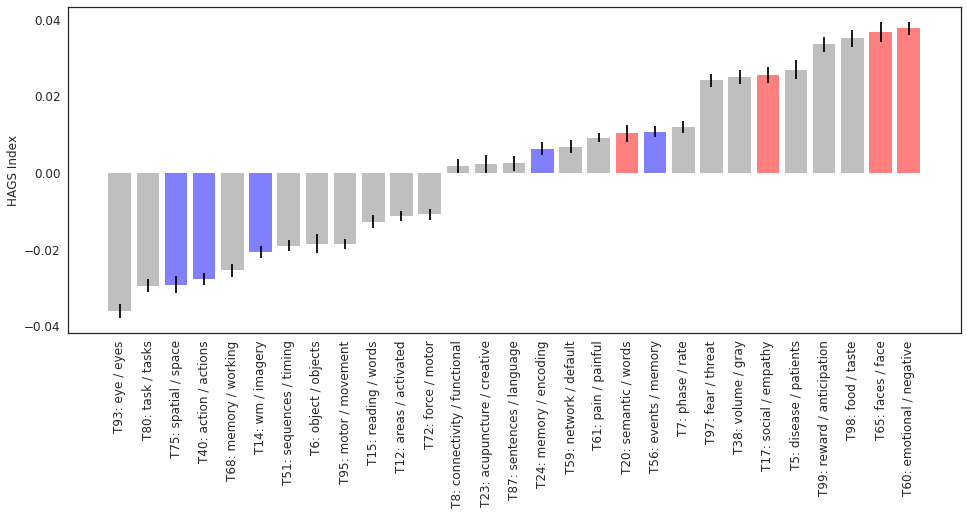

In [74]:
sns.set_context('notebook',font_scale=2)

# get mean and SEM data
means = (metares500.mean()).tolist()
stds = metares500.sem().tolist()
cis = [((means[x]-stds[x]),(means[x]+stds[x])) for x in range(len(means))]

# get labels
xlabs = ['%s: %s / %s'%(x.split('_')[0],
                x.split('_')[1],
                x.split('_')[2]) for x in metares500.mean().dropna().index.tolist()]

# get the range of the confidence interval
y_r = [((cis[i][0] - means[i]) + (means[i] - cis[i][1]))/2 for i in range(len(cis))]

# color code AT and PM bars
colors = ['red' if res_sum4.loc[x,'system'] == 'AT' else 'blue' if res_sum4.loc[x,'system'] == 'PM' else 'gray' for x in metares500.columns]

# Make a barplot
plt.close()
sns.set_style('white')
fig, ax = plt.subplots(figsize=(16,6))
fig = plt.bar(range(len(means)), means, yerr=y_r, alpha=0.5, align='center', color = colors,
             )
ax.set_xticks(range(len(means)))
ax.set_xticklabels(xlabs, rotation=90)
ax.set_ylabel('HAGGIS')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
#plt.savefig(os.path.join(fig_dir,'COG_t500_horiz_NEW.pdf'), 
#            bbox_inches='tight')
plt.show()

Here is the same thing, but vertical...

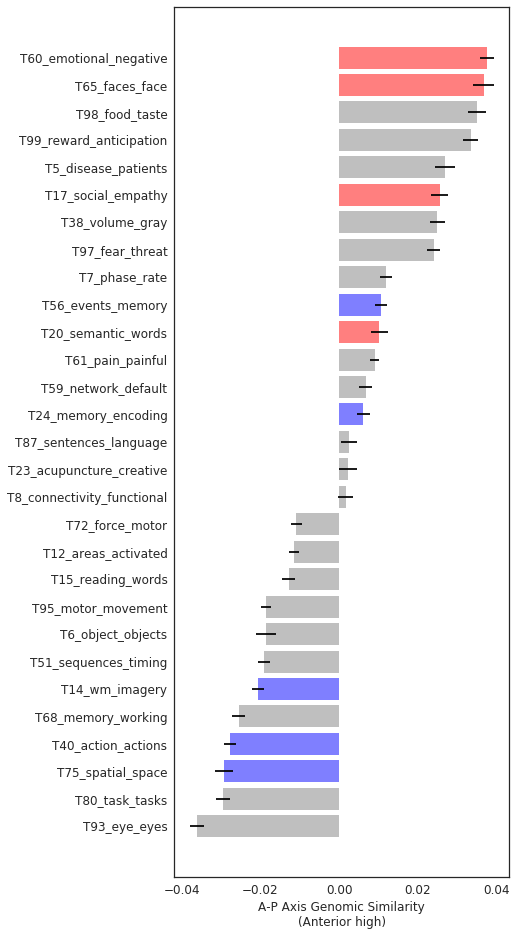

In [73]:
means = (metares500.mean()).tolist()
stds = metares500.sem().tolist()
cis = [((means[x]-stds[x]),(means[x]+stds[x])) for x in range(len(means))]

y_r = [((cis[i][0] - means[i]) + (means[i] - cis[i][1]))/2 for i in range(len(cis))]

colors = ['red' if res_sum4.loc[x,'system'] == 'AT' else 'blue' if res_sum4.loc[x,'system'] == 'PM' else 'gray' for x in metares500.columns]
plt.close()
sns.set_style('white')
fig, ax = plt.subplots(figsize=(6,16))
fig = plt.barh(range(len(means)), means, xerr=y_r, alpha=0.5, align='center', color = colors,
             )
ax.set_yticks(range(len(means)))
ax.set_yticklabels(metares500.mean().dropna().index.tolist())
ax.set_xlabel('A-P Axis Genomic Similarity\n(Anterior high)')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
#plt.savefig(os.path.join(fig_dir,'COG_t500_vert_NEW.pdf'), 
#            bbox_inches = 'tight')
plt.show()

### Generate a word cloud!

These word clouds will be generated by taking the topics associated with each map and weighting them first by order of importance within their own topic list, and then by the average HAGGIS of samples within the map to which the topic list is paired. Therefore, the largest words will be those that are most important to the topic maps that have the highest (or lowest) HAGGIS, with multiple mentions across topic maps resulting in even higher weights.

#### Get the strings

In [11]:
wdf = pandas.ExcelFile(os.path.join(git_dir,'text_descriptions.xlsx')
                      ).parse('Sheet1')
wdf.head()

,TOPIC,DESCRIPTION
0,0,"stimulation, somatosensory, tms, tactile, prim..."
1,1,"human, humans, animal, neurons, monkey, eviden..."
2,2,"smokers, users, smoking, drug, nicotine, cocai..."
3,3,"effect, increased, participants, level, behavi..."
4,4,"stress, ptsd, exposure, trauma, cortisol, diso..."


#### Anterior

In [87]:
ant_words = []
for i, val in metares500.mean().items():
    # anterior topics only (HAGGIS closer to Anterior)
    if val > 0:
        # get topic number
        topic = int(i.split('_')[0].split('T')[-1])
        # get words associated with this topic
        desc = wdf.loc[topic,'DESCRIPTION'].split(',')
        # get weight based on HAGGIS
        Gwt = int(round(val*1000))
        for i,word in enumerate(desc):
            # get rid of surrounding spaces
            word = word.strip()
            # get rough weight based on LDA relevance
            Lwt = 40 - i
            # get final weight
            Fwt = Gwt * Lwt
            w_string = [word] * Fwt
            ant_words += w_string

In [88]:
# now shuffle the words...
jnk = np.array(ant_words)
np.random.shuffle(jnk)

# ...and turn them into string
ant_words = ''
for word in jnk:
    ant_words += (word+' ')

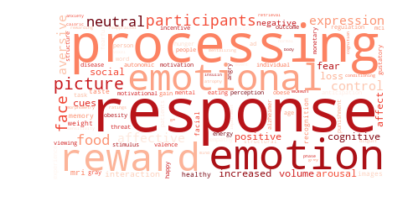

In [33]:
plt.close()
wc = wordcloud.WordCloud(max_words=100, background_color="white", colormap='Reds_r').generate(ant_words)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
#plt.savefig('os.path.join(fig_dir,'WordCloud_ant.pdf'),
#           bbox_inches='tight')
plt.show()

#### posterior

In [81]:
post_words = []
for i, val in (metares500.mean() * -1).items():
    # posterior topics only (HAGGIS closer to Anterior)
    if val > 0:
        # get topic number
        topic = int(i.split('_')[0].split('T')[-1])
        # get words associated with this topic
        desc = wdf.loc[topic,'DESCRIPTION'].split(',')
        # get weight based on HAGGIS
        Gwt = int(round(val*1000))
        for i,word in enumerate(desc):
            # get rid of surrounding spaces
            word = word.strip()
            # get rough weight based on LDA relevance
            Lwt = 40 - i
            # get final weight
            Fwt = Gwt * Lwt
            w_string = [word] * Fwt
            post_words += w_string

In [82]:
# now shuffle the words...
jnk = np.array(post_words)
np.random.shuffle(jnk)

# ...and turn them into string
post_words = ''
for word in jnk:
    post_words += (word+' ')

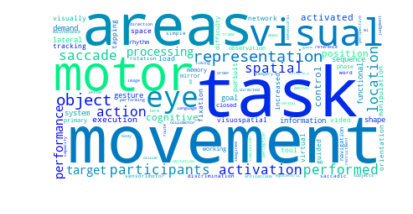

In [36]:
plt.close()
wc = wordcloud.WordCloud(max_words=100, background_color="white", colormap='winter').generate(post_words)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
#plt.savefig(os.path.join(fig_dir,'WordCloud_post.pdf'),
#           bbox_inches='tight')
plt.show()

Okay, that all looks good. But it would be great to be able to summarize both spatial (i.e. function coactivation) and semantic (i.e. cognitive topics) in one figure. Below, we will attempt to do that.

First, we will create a summary map that is a weighted average of all 29 cognitive maps, where the weights are determined by the average HAGGIS within the map (i.e. values represented by the bars in the figures above). Second, we will create outlines of these maps and try to fit the word clouds above inside of them 

### Generate a summary map

In [63]:
ex = ni.load(metascans[0]) # load an image so as to grab the affine
sum_map = np.zeros_like(ex.get_data()) # make an empty image

for i in metares500.mean().index: # for each of the 29 topic/map pairs
    val = metares500.mean()[i] # get the mean HAGGIS within the map
    
    # load and binarize the map
    fmap = ni.load([x for x in metascans if '_%s_'%i.split('_')[0].split('T')[-1] in x][0]).get_data()
    fmap[fmap>0] = 1
    fmap[fmap<1] = 0
    
    fmap *= val # weight map by mean HAGGIS within map
    sum_map += fmap # add to the (previously empty) image
    print('finished',i) # keep track of progress

finished T93_eye_eyes
finished T80_task_tasks
finished T75_spatial_space
finished T40_action_actions
finished T68_memory_working
finished T14_wm_imagery
finished T51_sequences_timing
finished T6_object_objects
finished T95_motor_movement
finished T15_reading_words
finished T12_areas_activated
finished T72_force_motor
finished T8_connectivity_functional
finished T23_acupuncture_creative
finished T87_sentences_language
finished T24_memory_encoding
finished T59_network_default
finished T61_pain_painful
finished T20_semantic_words
finished T56_events_memory
finished T7_phase_rate
finished T97_fear_threat
finished T38_volume_gray
finished T17_social_empathy
finished T5_disease_patients
finished T99_reward_anticipation
finished T98_food_taste
finished T65_faces_face
finished T60_emotional_negative


In [68]:
# Have a look at the image
sum_img = ni.Nifti1Image(sum_map, ex.affine)
plotting.view_img(image.smooth_img(sum_img,4)) # smooth arbitrarily by FWHM of 4
                                               # better shapes/outlines


/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


In [70]:
# Save image
image.smooth_img(sum_img, 4).to_filename(os.path.join(fig_dir,'/summary_map_smth4mm'))


At this point, you will need to do the following:
* Render the image on a brain with your favorite rendering software (I used Caret5)
* Set scale so that there are only two colors representing positive and negative values
* Take a screenshot of the rendered image
* open the screenshot in your favorite image editor (I used Adobe CS6 Photoshop)
* Do your best to extract the outline for the positive and negative maps, separately
* Copy and paste the image somewhere else, and save it as a .png file

In [ ]:
# Put the paths to your image here:
p_path = '/home/users/jvogel/Desktop/brain_p.png'
a_path = '/home/users/jvogel/Desktop/brain_a.png'

In [90]:
# Open and mask the image
pmask = np.array(PIL.Image.open(p_path))
pmask[pmask!=255] = 1

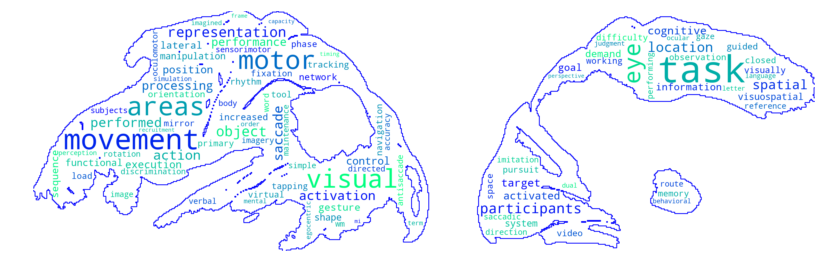

In [106]:
# And plot it!
plt.close()
plt.subplots(figsize=(14,8))
wc = wordcloud.WordCloud(max_words=100, background_color="white", contour_width=3,
                         contour_color='blue', mask = pmask, colormap='winter'
                        ).generate(post_words)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
#plt.savefig(os.path.join(fig_dir,'WordCloud_BRAIN_NC_post.pdf'),
#           bbox_inches='tight')
plt.show()

In [96]:
# Do the same for the anterior
amask = np.array(PIL.Image.open(a_path))
amask[amask!=255] = 1

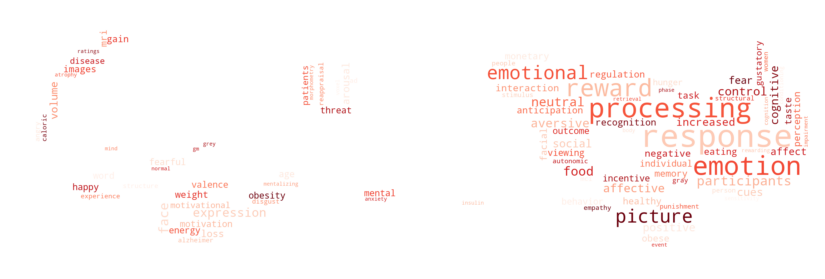

In [104]:
# Notice here that contour_width is set to 0, so there is no wall around the word cloud
plt.close()
plt.subplots(figsize=(14,8))
wc = wordcloud.WordCloud(max_words=100, background_color="white", contour_width=0,
                         contour_color='red', mask = amask, colormap='Reds_r'
                        ).generate(ant_words)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
#plt.savefig(os.path.join('WordCloud_BRAIN_NC_ant.pdf'),
#           bbox_inches='tight')
plt.show()

### Repeating analysis with maps overlapping with at least 100 samples (instead of 500)
I put a bunch of the previous stuff in a handy pipeline so plots can be generated easily

>>>Calculating stuff<<<
90 maps did not overlap with any samples
>>>removing data with less than 100 samples overlapping
63 maps remaining
>>>plotting<<<


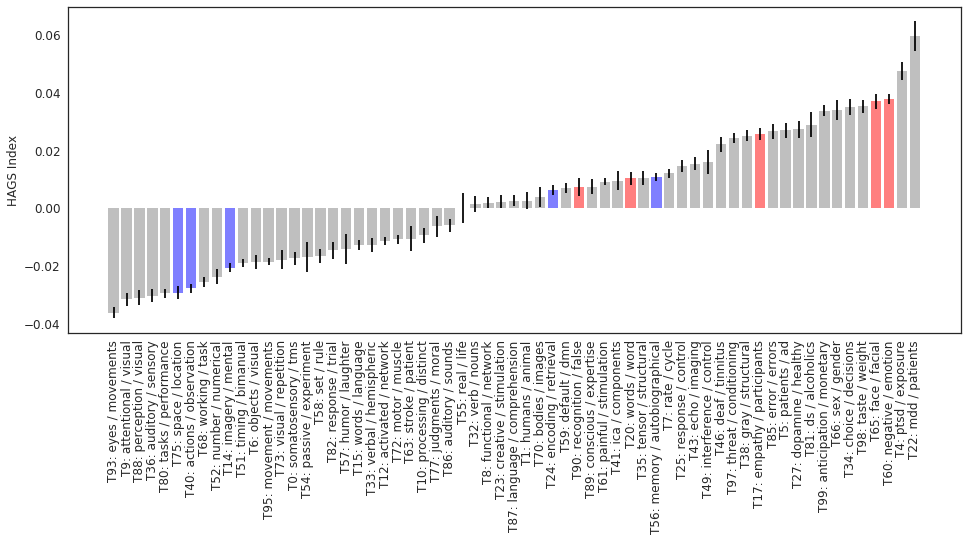

In [37]:
c_res = hap.cognitive_metaanalysis_pipeline(metares=metares_a, min_samples=100)

#### And some word clouds for this list...

In [41]:
ant_words = []
for i, val in c_res['metares100'].mean().items():
    # anterior topics only (HAGGIS closer to Anterior)
    if val > 0:
        # get topic number
        topic = int(i.split('_')[0].split('T')[-1])
        # get words associated with this topic
        desc = wdf.loc[topic,'DESCRIPTION'].split(',')
        # get weight based on HAGGIS
        Gwt = int(round(val*1000))
        for i,word in enumerate(desc):
            # get rid of surrounding spaces
            word = word.strip()
            # get rough weight based on LDA relevance
            Lwt = 40 - i
            # get final weight
            Fwt = Gwt * Lwt
            w_string = [word] * Fwt
            ant_words += w_string
            
# now shuffle the words...
jnk = np.array(ant_words)
np.random.shuffle(jnk)

# ...and turn them into string
ant_words = ''
for word in jnk:
    ant_words += (word+' ')


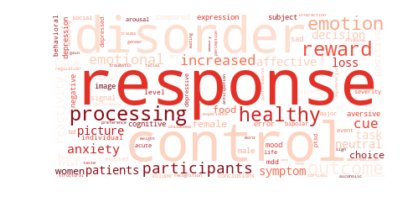

In [42]:
plt.close()
wc = wordcloud.WordCloud(max_words=100, background_color="white", 
                         colormap='Reds').generate(ant_words)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
#plt.savefig(os.path.join(fig_dir,'WordCloud_ant_s100.pdf'),
#           bbox_inches='tight')
plt.show()

In [43]:
post_words = []
for i, val in (c_res['metares100'].mean() * -1).items():
    # posterior topics only (HAGGIS closer to Anterior)
    if val > 0:
        # get topic number
        topic = int(i.split('_')[0].split('T')[-1])
        # get words associated with this topic
        desc = wdf.loc[topic,'DESCRIPTION'].split(',')
        # get weight based on HAGGIS
        Gwt = int(round(val*1000))
        for i,word in enumerate(desc):
            # get rid of surrounding spaces
            word = word.strip()
            # get rough weight based on LDA relevance
            Lwt = 40 - i
            # get final weight
            Fwt = Gwt * Lwt
            w_string = [word] * Fwt
            post_words += w_string

# now shuffle the words...
jnk = np.array(post_words)
np.random.shuffle(jnk)

# ...and turn them into string
post_words = ''
for word in jnk:
    post_words += (word+' ')

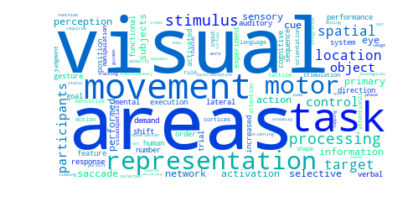

In [44]:
plt.close()
wc = wordcloud.WordCloud(max_words=100, background_color="white", 
                         colormap='winter').generate(post_words)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
#plt.savefig(os.path.join(fig_dir,'WordCloud_post_s100.pdf'),
#           bbox_inches='tight')
plt.show()

### Repeat original analysis, but this time from scratch and using only Gene Set1 instead of all genes 

In [6]:
gdf = pandas.read_csv(os.path.join(wdir,'MAIN_gcx_wholebrain_info_W_SMALL_SETS.csv'))

>>>loading data<<<
>>>computing overlap of each sample with each map<<<
finished 0 of 3702
finished 100 of 3702
finished 200 of 3702
finished 300 of 3702
finished 400 of 3702
finished 500 of 3702
finished 600 of 3702
finished 700 of 3702
finished 800 of 3702
finished 900 of 3702
finished 1000 of 3702
finished 1100 of 3702
finished 1200 of 3702
finished 1300 of 3702
finished 1400 of 3702
finished 1500 of 3702
finished 1600 of 3702
finished 1700 of 3702
finished 1800 of 3702
finished 1900 of 3702
finished 2000 of 3702
finished 2100 of 3702
finished 2200 of 3702
finished 2300 of 3702
finished 2400 of 3702
finished 2500 of 3702
finished 2600 of 3702
finished 2700 of 3702
finished 2800 of 3702
finished 2900 of 3702
finished 3000 of 3702
finished 3100 of 3702
finished 3200 of 3702
finished 3300 of 3702
finished 3400 of 3702
finished 3500 of 3702
finished 3600 of 3702
finished 3700 of 3702
>>>Calculating stuff<<<
90 maps did not overlap with any samples
>>>removing data with less than 500 sam

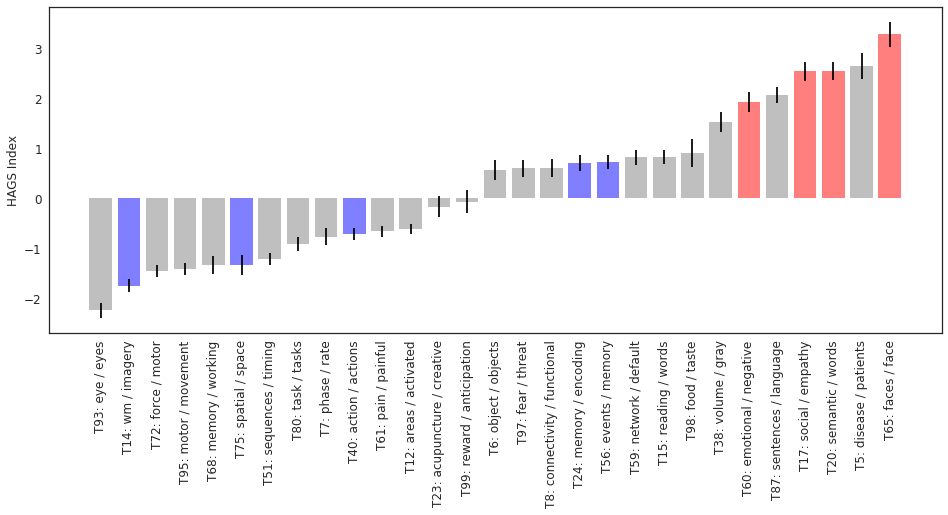

In [8]:
c_res = hap.cognitive_metaanalysis_pipeline(scans = metascans, gdf = gdf, target_col = 'vec100',
                               labels = metalabs, figtype = 'horizontal', 
                               # savefig = os.path.join(fig_dir,'COG_t500_vert_G100_NEW.pdf')
                                           )

#### Lets wordcloud this one too

In [12]:
ant_words = []
for i, val in c_res['metares500'].mean().items():
    # anterior topics only (HAGGIS closer to Anterior)
    if val > 0:
        # get topic number
        topic = int(i.split('_')[0].split('T')[-1])
        # get words associated with this topic
        desc = wdf.loc[topic,'DESCRIPTION'].split(',')
        # get weight based on HAGGIS -- here we weight differently based on effect size
        Gwt = int(round(val*100))
        for i,word in enumerate(desc):
            # get rid of surrounding spaces
            word = word.strip()
            # get rough weight based on LDA relevance
            Lwt = 40 - i
            # get final weight
            Fwt = Gwt * Lwt
            w_string = [word] * Fwt
            ant_words += w_string
            
# now shuffle the words...
jnk = np.array(ant_words)
np.random.shuffle(jnk)

# ...and turn them into string
ant_words = ''
for word in jnk:
    ant_words += (word+' ')


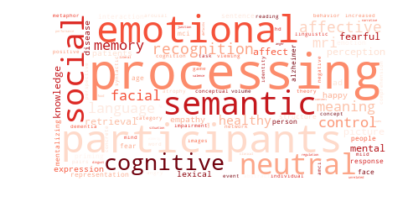

In [16]:
plt.close()
wc = wordcloud.WordCloud(max_words=100, background_color="white", 
                         colormap='Reds').generate(ant_words)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
#plt.savefig(os.path.join(fig_dir,'WordCloud_ant_t500_G100.pdf'),
#           bbox_inches='tight')
plt.show()

In [81]:
post_words = []
for i, val in (c_res['metares500'].mean() * -1).items():
    # posterior topics only (HAGGIS closer to Anterior)
    if val > 0:
        # get topic number
        topic = int(i.split('_')[0].split('T')[-1])
        # get words associated with this topic
        desc = wdf.loc[topic,'DESCRIPTION'].split(',')
        # get weight based on HAGGIS -- here we weight differently based on effect size
        Gwt = int(round(val*100))
        for i,word in enumerate(desc):
            # get rid of surrounding spaces
            word = word.strip()
            # get rough weight based on LDA relevance
            Lwt = 40 - i
            # get final weight
            Fwt = Gwt * Lwt
            w_string = [word] * Fwt
            post_words += w_string

# now shuffle the words...
jnk = np.array(post_words)
np.random.shuffle(jnk)

# ...and turn them into string
post_words = ''
for word in jnk:
    post_words += (word+' ')

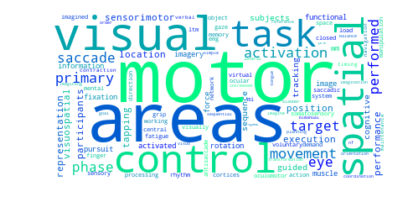

In [82]:
plt.close()
wc = wordcloud.WordCloud(max_words=100, background_color="white", 
                         colormap='winter').generate(post_words)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
#plt.savefig(os.path.join(fig_dir,'WordCloud_post_t500_G100.pdf'),
#           bbox_inches='tight')
plt.show()

And that's all folks